# Import Libraries

In [1]:
from __future__ import print_function
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
best_acc1 = 0
tmp_best_acc1 = 0

### Optimum values found for L1-penalty-weight & L2-weight-decay
    - The appropriate values for l1 & l2 related weights were found after coarsely sweeping thru values from 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001 first.
    - For l1-weight, with l1-alone enabled, the 0.00001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.00001 region, led to the value: 0.000025, which seems to be having best accuracy values.
    - Similarly, For l2-weight,  with l2-alone enabled, the 0.0001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.0001 region, led to the value: 0.0002125, which seems to be having best accuracy values.
    - For individual models, either or both of them will be enabled/disbaled using some related flags defined ahead in this notebook
    - Please note, L2 regaularization implementation is in-built with torch. 

In [3]:
l1_weight = 0.000025 ##Appears to be the best with the reference NW we have used here
l2_weight_decay = 0.0002125 ##Appears to be the best with the reference NW we have used here

In [4]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [5]:
class_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

##  Dataset and Creating Train/Test Split & Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [6]:
# # load the training data
# cifar10_train = datasets.CIFAR10('./data', train=True, download=True)
# # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
# x = np.concatenate([np.asarray(cifar10_train[i][0]) for i in range(len(cifar10_train))])
# # print(x)
# print(x.shape)
# # calculate the mean and std along the (0, 1) axes
# train_mean = np.mean(x, axis=(0, 1))/255
# train_std = np.std(x, axis=(0, 1))/255
# # the the mean and std
# print(train_mean, train_std)

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                                       ])

In [8]:
train_cifar10 = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_cifar10 = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_cifar10, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_cifar10, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


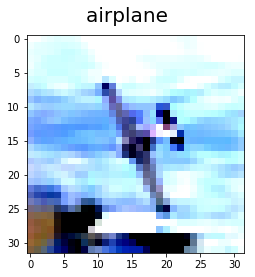

In [11]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = torch.from_numpy(train_cifar10.data)
print('[Train]')
print(' - Numpy Shape:', torch.from_numpy(train_cifar10.data).cpu().numpy().shape)
print(' - Tensor Shape:', torch.from_numpy(train_cifar10.data).size())
print(' - min:', torch.min(torch.from_numpy(train_cifar10.data)))
print(' - max:', torch.max(torch.from_numpy(train_cifar10.data)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
img_number = np.random.randint(images.shape[0])
plt.figure().suptitle('{} '.format(class_names[labels[img_number]]), fontsize=20)
plt.imshow(images.numpy().squeeze()[img_number,::].transpose((1,2,0)), interpolation='nearest')

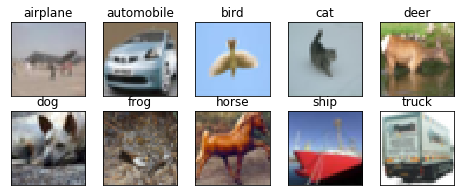

In [11]:
num_classes = len(np.unique(train_cifar10.targets))
num_classes
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(np.array(train_cifar10.targets)[:]==i)[0]
    features_idx = train_cifar10.data[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Training and Testing related routines

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [12]:
def l1_penalty(x):
    #L1 regularization adds an L1 penalty equal
    #to the absolute value of the magnitude of coefficients
    return torch.abs(x).sum()

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        #L1 regularization adds an L1 penalty equal to the 
        #absolute value of the magnitude of coefficients
        loss = F.nll_loss(y_pred, target) + l1 #torch.nn.CrossEntropyLoss:criterion combines
                                               #nn.LogSoftmax() and nn.NLLLoss() in one single class.    
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader, epoch):
    global best_acc1, tmp_best_acc1
    model.eval()
    test_loss = 0
    correct = 0
    acc1 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc1 = 100. * correct / len(test_loader.dataset)
    is_best = acc1 > best_acc1
    tmp_best_acc1 = best_acc1
    best_acc1 = max(acc1, best_acc1)
    # Prepare model model saving directory.
    if is_best:
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        model_name = 'CIFAR10_model_epoch-{}_L1-{}_L2-{}_val_acc-{}.h5'.format(epoch+1, int(L1), int(L2), acc1) 
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        filepath = os.path.join(save_dir, model_name)
        print("validation-accuracy improved from {} to {}, saving model to {}".format(tmp_best_acc1, best_acc1, filepath))
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename=filepath)
    test_acc.append(100. * correct / len(test_loader.dataset))

### model-prediction & mislabelled image display related routines


In [13]:
def model_pred(model, device, y_test, batchsize=test_cifar10.data.shape[0]):
    from sklearn.metrics import confusion_matrix, classification_report
    model.eval()
    dataldr_args = dict(shuffle=False, batch_size=batchsize, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10000)
    test_ldr = torch.utils.data.DataLoader(test_cifar10, **dataldr_args)
    with torch.no_grad():
        for data, target in test_ldr:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred = y_pred.cpu().numpy()
    print(confusion_matrix(y_test, y_pred.reshape(-1)))
    print('\n')
    print(classification_report(y_test, y_pred.reshape(-1), target_names=class_names))
    return y_pred


def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(30,9))
    fig.suptitle(title_str, fontsize=24)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            img_num = np.random.randint(features_idx.shape[0])
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(i) + ' Pred:{} '.format(y_pred[intsct[img_num]][0]), fontsize=20)
            plt.imshow(im)
    plt.show()

### routine to load any model from saved file

In [14]:
def load_model(describe_model_nn, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    model = describe_model_nn #describe_model_nn is for example: Net1()
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    return  model

### routine to save & load the validation-accuracy & validation-loss data  for any model

In [15]:
def save_acc_loss(test_losses, test_acc, test_loss_file_name,  test_acc_file_name):
    import os
    import numpy as np
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    np.save(filepath_test_loss,test_losses)
    np.save(filepath_test_acc,test_acc)
    

def load_acc_loss(test_loss_file_name,  test_acc_file_name):
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    loaded_test_losses = np.load(filepath_test_loss).tolist()
    loaded_test_acc = np.load(filepath_test_acc).tolist()
    return loaded_test_losses, loaded_test_acc

### routine to plot 4 accuracies and 4 losses in 2 separate plots

In [16]:
def plot_curves(first_acc, second_acc, third_acc, fourth_acc,
                first_loss, second_loss, third_loss, fourth_loss):
    fig, axs = plt.subplots(1,2,figsize=(20,10))
    _= axs[0].plot(first_acc)
    _= axs[0].plot(second_acc)
    _= axs[0].plot(third_acc)
    _= axs[0].plot(fourth_acc)
    _= axs[0].set_title('model test accuracies', fontsize=22)
    _= axs[0].set_ylabel('test-accuracy', fontsize=18)
    _= axs[0].set_xlabel('epoch', fontsize=18)
    _= axs[0].legend(['without L1 & L2', 'with L1 alone', 'with L2 alone', 'with both L1 & L2'], loc='upper left')
    _= axs[1].plot(first_loss)
    _= axs[1].plot(second_loss)
    _= axs[1].plot(third_loss)
    _= axs[1].plot(fourth_loss)
    _= axs[1].set_title('model test losses', fontsize=22)
    _= axs[1].set_ylabel('test-loss', fontsize=18)
    _= axs[1].set_xlabel('epoch', fontsize=18)
    _= axs[1].legend(['without L1 & L2', 'with L1 alone', 'with L2 alone', 'with both L1 & L2'], loc='upper right')

# The model
Let's start with the model we first saw, the base-line/refernce model being used here is as shown in the table below:
Please note that my earlier assignment's 5th model had a learning rate-step-LR based change in learning rate, to enter a crevice of higher accuracy within 15 epochs.The same if used as a baseline will have this extra LR as a variable.The effects of L1 & L2 penalties would not be obvious for that earlier NW, hence am starting out with the 3rd Stable NW from assignment-5


Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`  **Input Block** [1 conv2d 3x3 layer]    
` `              | `BN(8)`   |      ` `  |      ` `
` `              | `Dropout(10%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
`26x26x8`             | `(3x3x8)x8`  |      `24x24x8` |      `5x5`     **CONVOLUTION BLOCK 1** [1 conv2d 3x3 layer ]
` `              | `BN(8)`   |      ` `  |      ` `
` `              | `Dropout(10%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
**24x24x8**             |   **MP(2x2)**    |     **12x12x8**   |     **6x6**  **TRANSITION BLOCK 1**  [1 maxpool(2,2) & 1 conv2d 1x1 layers]                     
**12x12x8**             | **(1x1x8)x8**  |     **12x12x8**   |      **6x6** 
** **             | **Dropout(10%)**   |     ** **  |     ** **
** **             | **BN(8)**   |     ** **  |     ** **
** **             | **ReLU**   |     ** **  |     ** **      
*12x12x8*             | *(3x3x8)x16*  |      *10x10x16* |      *10x10*  **CONVOLUTION BLOCK 2** [4 conv2d 3x3 layers]
** **            | *BN(16)*   |     * *   |     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **                       
*10x10x16*             | *(3x3x16)x16*  |      *8x8x16* |      *14x14* 
** **            | *BN(16)*   |     * *   10%|     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **    
*8x8x16*               | *(3x3x16)x16*  |      *6x6x16*  |      *18x18* 
** **            | *BN(16)*   |     * *   |     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **   
*6x6x16*               | *(3x3x16)x20*  |      *6x6x20*  |      *22x22* (**Note 1:** o/p channels should be generated after *padding* here, hence you see *6x6* rather than 4x4.In terms of accuracy for 4x4 vs 6x6, it comes out to be better for 6x6, hence padding recommended here.   **Note 2:** also note that this 4x4 vs 6x6 has significance for the upcoming grad-cam assisted visualizations)
** **            | *BN(20)*   |     * *   |     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **   
6x6x20               | GAP  LAYER (kernel_size=(6,6)   |      1x1x20          | `32x32` (22 + (6-1)x2 = 32)**OUTPUT BLOCK** [GAP + 1 conv2d 1x1 layer]
`1x1x20`               | `(1x1x20)x10`  |      `1x1x10`    |      ` `  (NO RELU at the o/p of this layer) 
` `             | `log_SoftMax`   |     ` `  |     ` ` 

# 1. model,  40 epochs, without L1/L2

In [17]:
L1 = True #without L1-penalty 
L2 = False #without L2-penalty

In [18]:
dropout_value = 0.05
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # C1 Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, bias=False, dilation=2),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # C2 Block
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        
        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        
        # C3 Block
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        
        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6  
        
        # C4 Block
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # C1 Block
        x = self.convblock1(x)
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # C2 Block
        x = self.convblock4(x)
        # TRANSITION BLOCK 2
        x = self.pool2(x)
        x = self.convblock5(x)
        # C3 Block
        x = self.convblock6(x)
        # TRANSITION BLOCK 3
        x = self.pool3(x)
        x = self.convblock7(x)
        # C4 Block
        x = self.convblock8(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock9(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1) #torch.nn.CrossEntropyLoss:criterion combines
                                        #nn.LogSoftmax() and nn.NLLLoss() in one single class.

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [19]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model1 = Net1().to(device)
summary(model1, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
           Dropout-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,048
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
             ReLU-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1

# Let's Train and test our model

In [20]:
model1 =  Net1().to(device)
#Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model1, device, train_loader, optimizer, epoch)
    test(model1, device, test_loader, epoch)

EPOCH: 1


Loss=1.4040436744689941 Batch_id=781 Accuracy=47.56: 100%|███████████████████████████| 782/782 [00:56<00:00, 13.79it/s]



Test set: Average loss: 1.3129, Accuracy: 5276/10000 (52.76%)

validation-accuracy improved from 0 to 52.76, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-1_L1-1_L2-0_val_acc-52.76.h5
EPOCH: 2


Loss=0.8069711923599243 Batch_id=781 Accuracy=62.67: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.65it/s]



Test set: Average loss: 0.9611, Accuracy: 6521/10000 (65.21%)

validation-accuracy improved from 52.76 to 65.21, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-2_L1-1_L2-0_val_acc-65.21.h5
EPOCH: 3


Loss=1.4889543056488037 Batch_id=781 Accuracy=68.16: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.55it/s]



Test set: Average loss: 0.9141, Accuracy: 6736/10000 (67.36%)

validation-accuracy improved from 65.21 to 67.36, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-3_L1-1_L2-0_val_acc-67.36.h5
EPOCH: 4


Loss=0.7899762392044067 Batch_id=781 Accuracy=71.00: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.58it/s]



Test set: Average loss: 0.8863, Accuracy: 6815/10000 (68.15%)

validation-accuracy improved from 67.36 to 68.15, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-4_L1-1_L2-0_val_acc-68.15.h5
EPOCH: 5


Loss=0.7199451923370361 Batch_id=781 Accuracy=73.59: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.52it/s]



Test set: Average loss: 0.8061, Accuracy: 7165/10000 (71.65%)

validation-accuracy improved from 68.15 to 71.65, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-5_L1-1_L2-0_val_acc-71.65.h5
EPOCH: 6


Loss=0.8098833560943604 Batch_id=781 Accuracy=75.54: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.47it/s]



Test set: Average loss: 0.7490, Accuracy: 7346/10000 (73.46%)

validation-accuracy improved from 71.65 to 73.46, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-6_L1-1_L2-0_val_acc-73.46.h5
EPOCH: 7


Loss=0.8427687883377075 Batch_id=781 Accuracy=76.86: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.42it/s]



Test set: Average loss: 0.7450, Accuracy: 7365/10000 (73.65%)

validation-accuracy improved from 73.46 to 73.65, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-7_L1-1_L2-0_val_acc-73.65.h5
EPOCH: 8


Loss=0.8546695113182068 Batch_id=781 Accuracy=78.15: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.56it/s]



Test set: Average loss: 0.6910, Accuracy: 7595/10000 (75.95%)

validation-accuracy improved from 73.65 to 75.95, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-8_L1-1_L2-0_val_acc-75.95.h5
EPOCH: 9


Loss=0.9702503681182861 Batch_id=781 Accuracy=78.95: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.53it/s]



Test set: Average loss: 0.6863, Accuracy: 7616/10000 (76.16%)

validation-accuracy improved from 75.95 to 76.16, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-9_L1-1_L2-0_val_acc-76.16.h5
EPOCH: 10


Loss=0.6247991323471069 Batch_id=781 Accuracy=79.92: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.53it/s]



Test set: Average loss: 0.6465, Accuracy: 7745/10000 (77.45%)

validation-accuracy improved from 76.16 to 77.45, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-10_L1-1_L2-0_val_acc-77.45.h5
EPOCH: 11


Loss=0.40850862860679626 Batch_id=781 Accuracy=80.71: 100%|██████████████████████████| 782/782 [00:58<00:00, 13.36it/s]



Test set: Average loss: 0.6433, Accuracy: 7771/10000 (77.71%)

validation-accuracy improved from 77.45 to 77.71, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-11_L1-1_L2-0_val_acc-77.71.h5
EPOCH: 12


Loss=1.0868465900421143 Batch_id=781 Accuracy=81.31: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.47it/s]



Test set: Average loss: 0.6796, Accuracy: 7657/10000 (76.57%)

EPOCH: 13


Loss=0.6891504526138306 Batch_id=781 Accuracy=81.81: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.30it/s]



Test set: Average loss: 0.6762, Accuracy: 7696/10000 (76.96%)

EPOCH: 14


Loss=0.6588395833969116 Batch_id=781 Accuracy=82.31: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.52it/s]



Test set: Average loss: 0.6246, Accuracy: 7809/10000 (78.09%)

validation-accuracy improved from 77.71 to 78.09, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-14_L1-1_L2-0_val_acc-78.09.h5
EPOCH: 15


Loss=0.765507161617279 Batch_id=781 Accuracy=82.78: 100%|████████████████████████████| 782/782 [00:57<00:00, 13.55it/s]



Test set: Average loss: 0.5859, Accuracy: 7993/10000 (79.93%)

validation-accuracy improved from 78.09 to 79.93, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-15_L1-1_L2-0_val_acc-79.93.h5
EPOCH: 16


Loss=0.7546483874320984 Batch_id=781 Accuracy=83.19: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.51it/s]



Test set: Average loss: 0.5929, Accuracy: 7928/10000 (79.28%)

EPOCH: 17


Loss=0.3508344292640686 Batch_id=781 Accuracy=83.84: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.50it/s]



Test set: Average loss: 0.5919, Accuracy: 7938/10000 (79.38%)

EPOCH: 18


Loss=0.5395448207855225 Batch_id=781 Accuracy=83.96: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.39it/s]



Test set: Average loss: 0.5821, Accuracy: 8032/10000 (80.32%)

validation-accuracy improved from 79.93 to 80.32, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-18_L1-1_L2-0_val_acc-80.32.h5
EPOCH: 19


Loss=0.4617820382118225 Batch_id=781 Accuracy=84.17: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.46it/s]



Test set: Average loss: 0.6020, Accuracy: 7937/10000 (79.37%)

EPOCH: 20


Loss=0.29764968156814575 Batch_id=781 Accuracy=84.87: 100%|██████████████████████████| 782/782 [00:57<00:00, 13.53it/s]



Test set: Average loss: 0.5735, Accuracy: 8035/10000 (80.35%)

validation-accuracy improved from 80.32 to 80.35, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-20_L1-1_L2-0_val_acc-80.35.h5
EPOCH: 21


Loss=0.37299439311027527 Batch_id=781 Accuracy=84.84: 100%|██████████████████████████| 782/782 [00:57<00:00, 13.52it/s]



Test set: Average loss: 0.5680, Accuracy: 8054/10000 (80.54%)

validation-accuracy improved from 80.35 to 80.54, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-21_L1-1_L2-0_val_acc-80.54.h5
EPOCH: 22


Loss=0.3784373104572296 Batch_id=781 Accuracy=85.23: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.47it/s]



Test set: Average loss: 0.5986, Accuracy: 7966/10000 (79.66%)

EPOCH: 23


Loss=0.6430172324180603 Batch_id=781 Accuracy=85.51: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.32it/s]



Test set: Average loss: 0.5559, Accuracy: 8091/10000 (80.91%)

validation-accuracy improved from 80.54 to 80.91, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-23_L1-1_L2-0_val_acc-80.91.h5
EPOCH: 24


Loss=0.4028148949146271 Batch_id=781 Accuracy=85.57: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.38it/s]



Test set: Average loss: 0.5641, Accuracy: 8081/10000 (80.81%)

EPOCH: 25


Loss=0.5136103630065918 Batch_id=781 Accuracy=85.98: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.43it/s]



Test set: Average loss: 0.6042, Accuracy: 7954/10000 (79.54%)

EPOCH: 26


Loss=0.49178874492645264 Batch_id=781 Accuracy=86.07: 100%|██████████████████████████| 782/782 [00:58<00:00, 13.44it/s]



Test set: Average loss: 0.5701, Accuracy: 8084/10000 (80.84%)

EPOCH: 27


Loss=0.5319980382919312 Batch_id=781 Accuracy=86.43: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.52it/s]



Test set: Average loss: 0.5512, Accuracy: 8122/10000 (81.22%)

validation-accuracy improved from 80.91 to 81.22, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-27_L1-1_L2-0_val_acc-81.22.h5
EPOCH: 28


Loss=0.3178510367870331 Batch_id=781 Accuracy=86.69: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.49it/s]



Test set: Average loss: 0.5557, Accuracy: 8155/10000 (81.55%)

validation-accuracy improved from 81.22 to 81.55, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-28_L1-1_L2-0_val_acc-81.55.h5
EPOCH: 29


Loss=0.4143742620944977 Batch_id=781 Accuracy=86.81: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.42it/s]



Test set: Average loss: 0.5971, Accuracy: 7961/10000 (79.61%)

EPOCH: 30


Loss=0.2310495227575302 Batch_id=781 Accuracy=87.05: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.48it/s]



Test set: Average loss: 0.5495, Accuracy: 8121/10000 (81.21%)

EPOCH: 31


Loss=0.45353183150291443 Batch_id=781 Accuracy=87.24: 100%|██████████████████████████| 782/782 [00:58<00:00, 13.46it/s]



Test set: Average loss: 0.5341, Accuracy: 8187/10000 (81.87%)

validation-accuracy improved from 81.55 to 81.87, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-31_L1-1_L2-0_val_acc-81.87.h5
EPOCH: 32


Loss=0.848567008972168 Batch_id=781 Accuracy=87.43: 100%|████████████████████████████| 782/782 [00:58<00:00, 13.39it/s]



Test set: Average loss: 0.5549, Accuracy: 8178/10000 (81.78%)

EPOCH: 33


Loss=0.4626047909259796 Batch_id=781 Accuracy=87.30: 100%|███████████████████████████| 782/782 [00:57<00:00, 13.50it/s]



Test set: Average loss: 0.5562, Accuracy: 8105/10000 (81.05%)

EPOCH: 34


Loss=0.18391257524490356 Batch_id=781 Accuracy=87.50: 100%|██████████████████████████| 782/782 [00:57<00:00, 13.52it/s]



Test set: Average loss: 0.5647, Accuracy: 8084/10000 (80.84%)

EPOCH: 35


Loss=0.4383028745651245 Batch_id=781 Accuracy=87.73: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.44it/s]



Test set: Average loss: 0.5699, Accuracy: 8081/10000 (80.81%)

EPOCH: 36


Loss=1.0193829536437988 Batch_id=781 Accuracy=87.75: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.28it/s]



Test set: Average loss: 0.5572, Accuracy: 8139/10000 (81.39%)

EPOCH: 37


Loss=0.5850199460983276 Batch_id=781 Accuracy=88.05: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.42it/s]



Test set: Average loss: 0.5665, Accuracy: 8119/10000 (81.19%)

EPOCH: 38


Loss=0.5074845552444458 Batch_id=781 Accuracy=88.18: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.47it/s]



Test set: Average loss: 0.5664, Accuracy: 8105/10000 (81.05%)

EPOCH: 39


Loss=0.8475117683410645 Batch_id=781 Accuracy=88.28: 100%|███████████████████████████| 782/782 [00:58<00:00, 13.37it/s]



Test set: Average loss: 0.5724, Accuracy: 8114/10000 (81.14%)

EPOCH: 40


Loss=0.43148285150527954 Batch_id=781 Accuracy=88.40: 100%|██████████████████████████| 782/782 [00:58<00:00, 13.42it/s]



Test set: Average loss: 0.5336, Accuracy: 8192/10000 (81.92%)

validation-accuracy improved from 81.87 to 81.92, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-40_L1-1_L2-0_val_acc-81.92.h5


Text(0.5, 1.0, 'Test Accuracy')

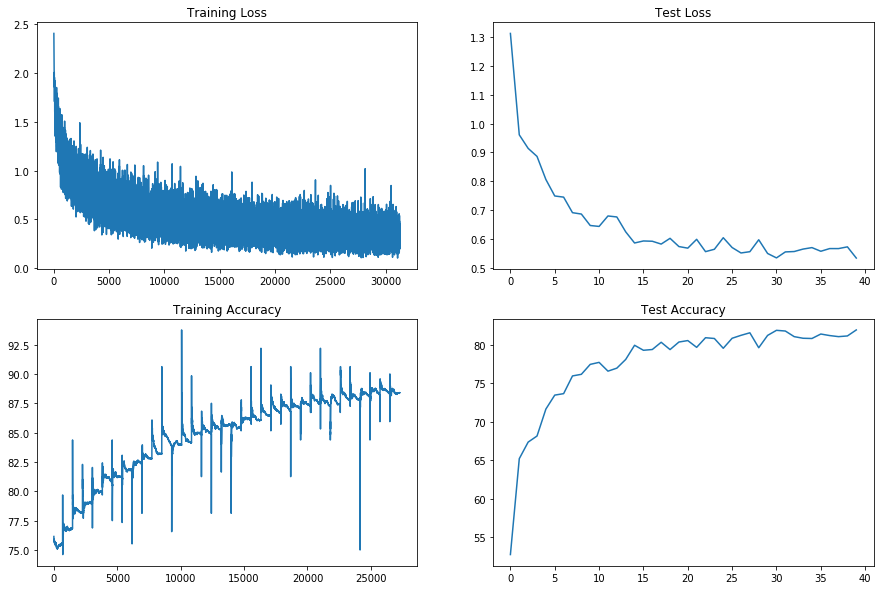

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### save the validation-accuracy & validation-loss data  for the  model without L1/L2

In [22]:
save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
              test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
             )

### an example load for the validation-accuracy & validation-loss data  for the  model without L1/L2
        - Once having saved as a file, these acc/loss values can be loaded anytime

In [23]:
#Load these data points later using code as below
test_loss_l1_0_l2_0, test_acc_l1_0_l2_0 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

Text(0.5, 1.0, 'Test Loss')

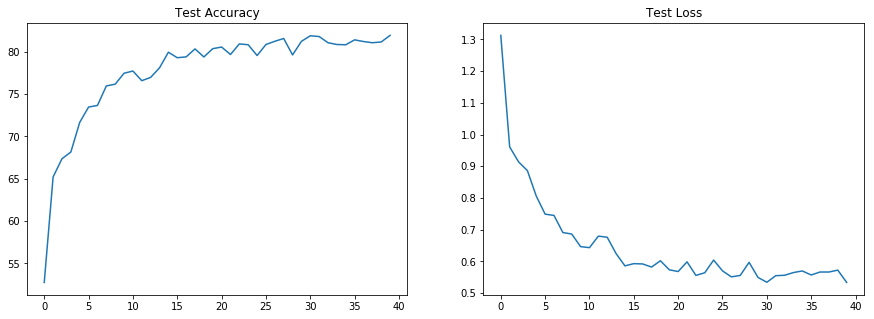

In [24]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_acc_l1_0_l2_0)
axs[0].set_title("Test Accuracy")
axs[1].plot(test_loss_l1_0_l2_0)
axs[1].set_title("Test Loss")